In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import math
import sympy
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LogisticRegression
import collections
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
import sklearn.preprocessing as prp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from mlxtend.classifier import StackingClassifier
from mlxtend.regressor import StackingRegressor
import xgboost as xgb

# Initialize data by reading in .csv files, set array of feature names and ID vals

In [4]:
# Read in data and initialize
train_final = pd.read_csv("./train_final.csv", header=0, index_col=0)
test_final = pd.read_csv("./test_final.csv", header=0, index_col=0)
id_val = test_final.index.values
a = ["F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","F11","F12","F13","F14",
     "F15","F16","F17","F18","F19","F20","F21","F22","F23","F24","F25","F26","F27"]

# Visualization of data

Y          1.000000
F1         1.000000
F2         1.000000
F3         1.034362
F4         0.000000
F5         3.000000
F6       221.000000
F7         1.000000
F8         1.000000
F9        12.000000
F10        3.000000
F11       48.000000
F12        1.000000
F13        1.000000
F14        1.000000
F15        1.000000
F16       21.240000
F17        1.000000
F18      155.000000
F19    14583.000000
F20        1.000000
F21       11.000000
F22       18.000000
F23        1.000000
F24        1.000000
F25        2.000000
F26       78.000000
F27     2474.000000
Name: 0.95, dtype: float64
id
1        1
2        1
3        1
4        1
5        1
6        2
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       2
28       1
29       1
30       1
        ..
49969    1
49970    1
49971    1
49972    1
49973    1
49974    1
499

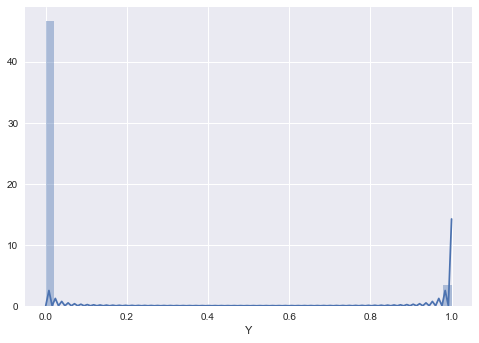

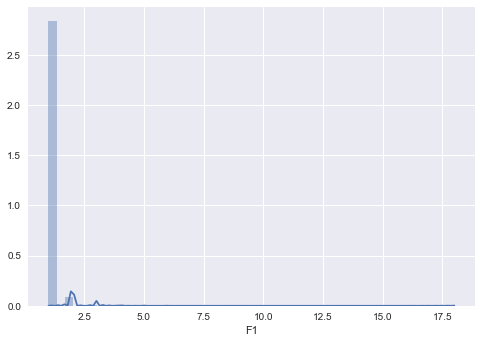

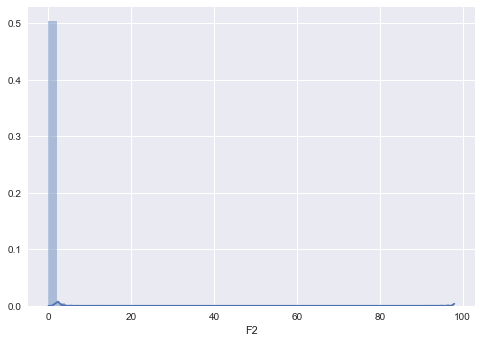

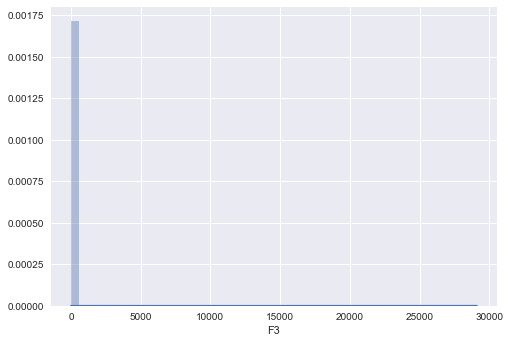

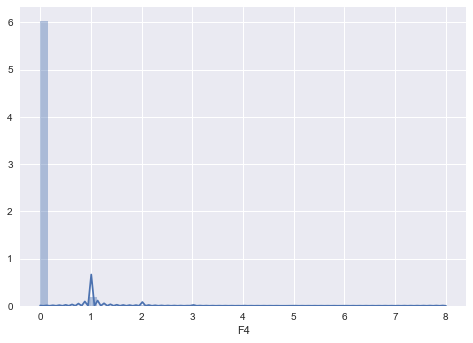

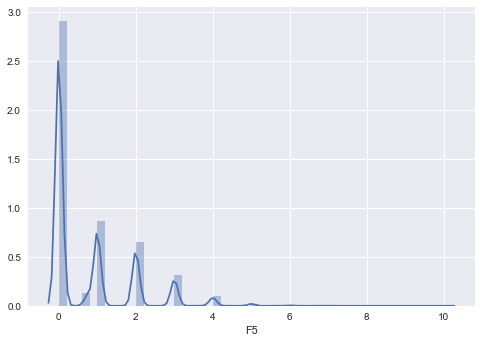

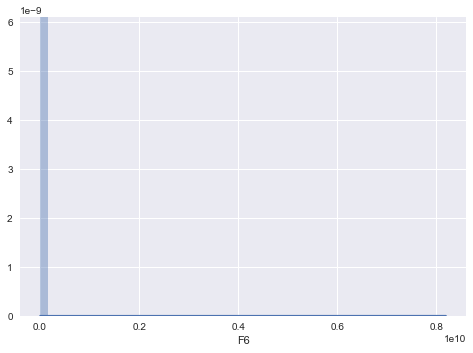

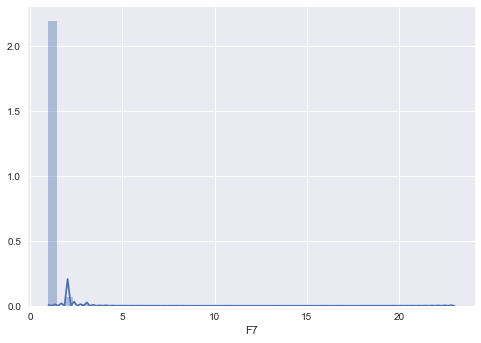

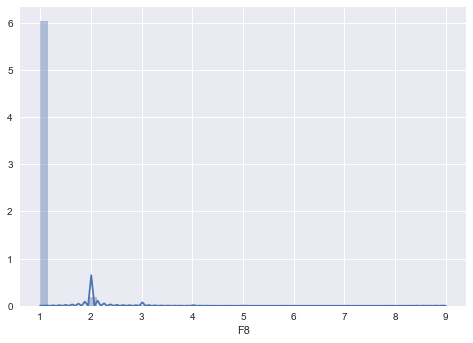

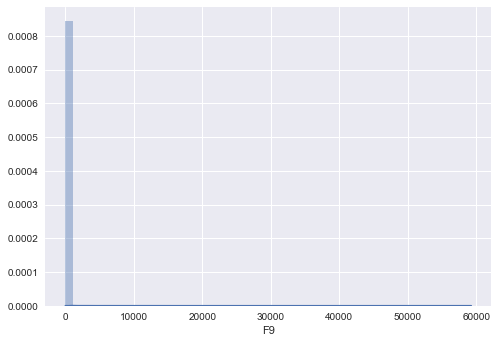

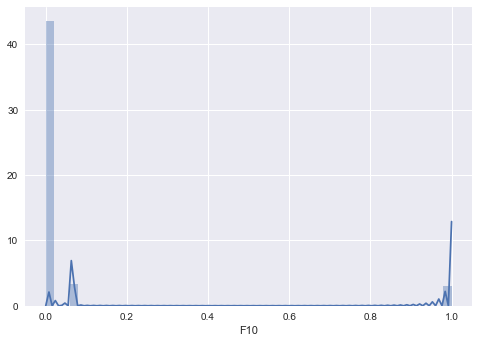

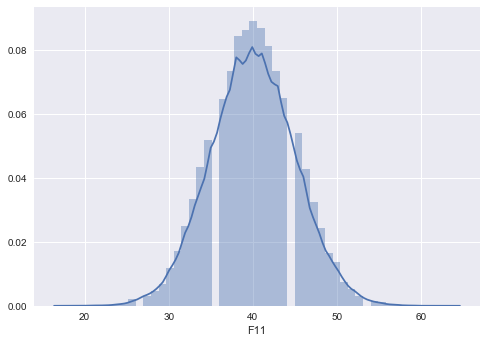

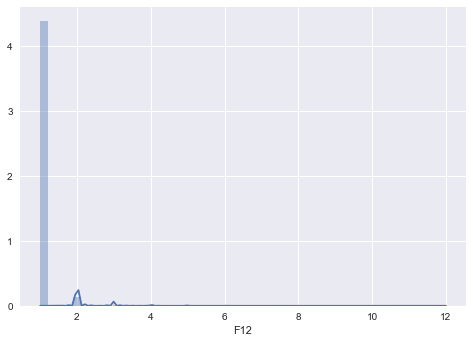

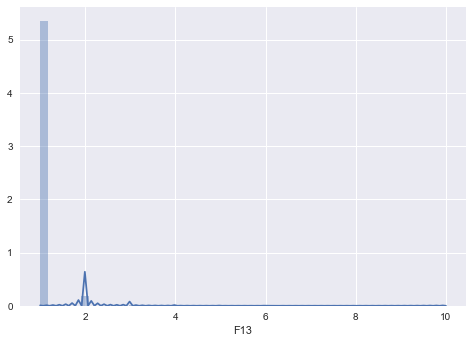

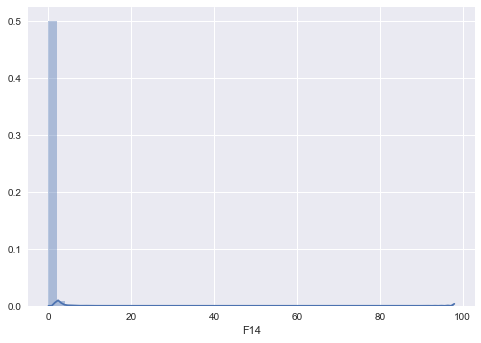

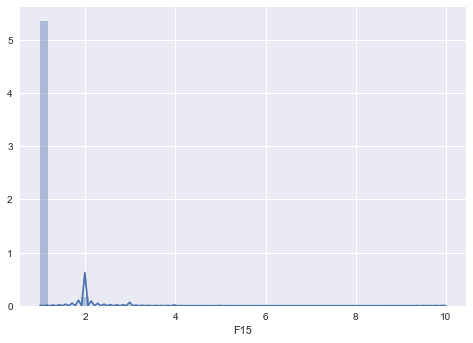

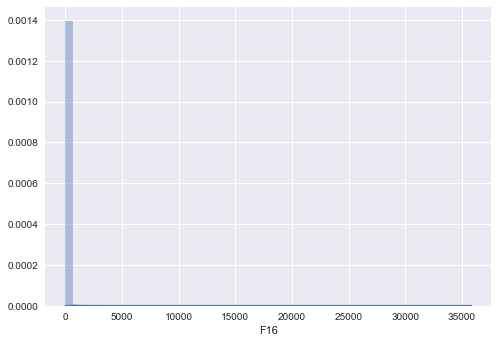

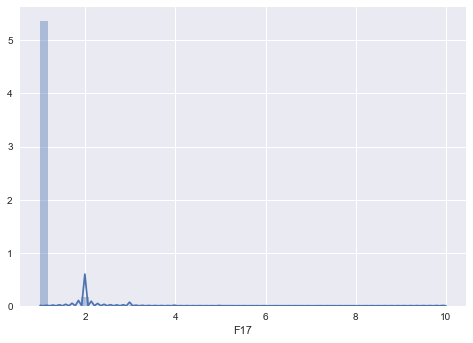

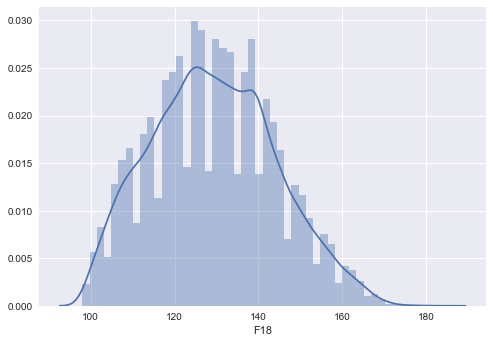

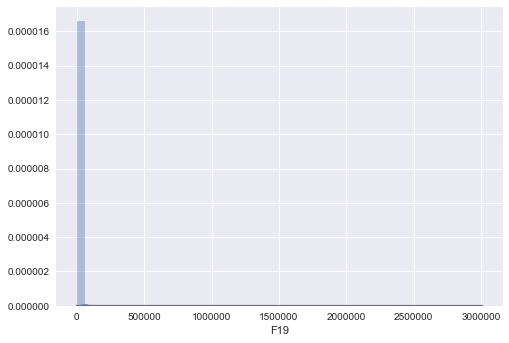

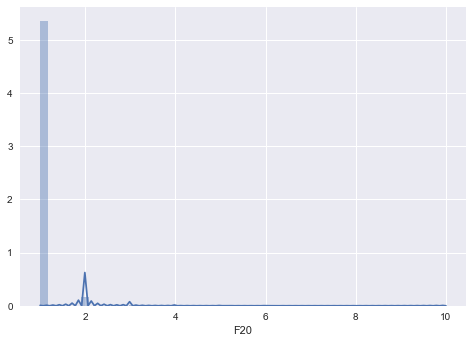

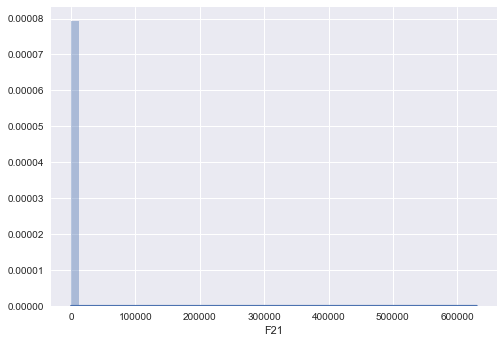

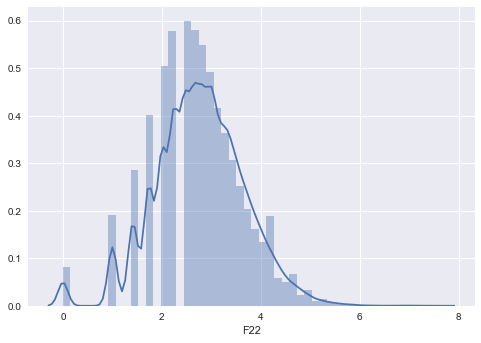

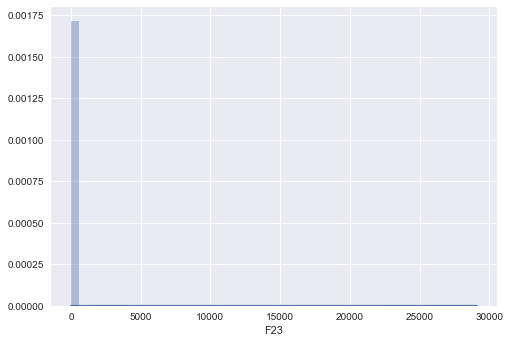

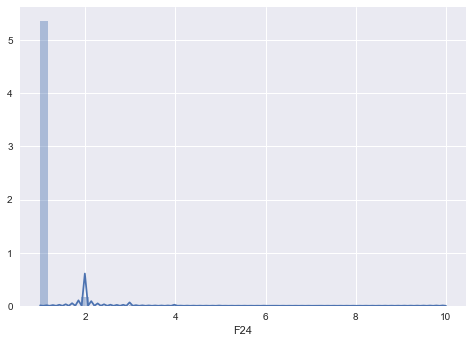

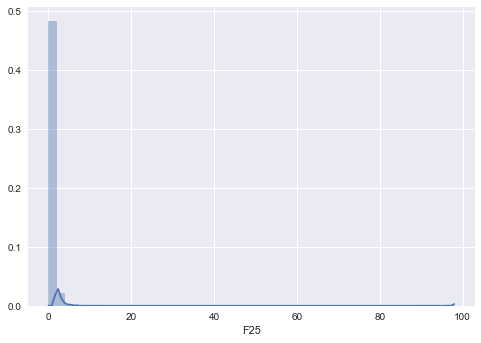

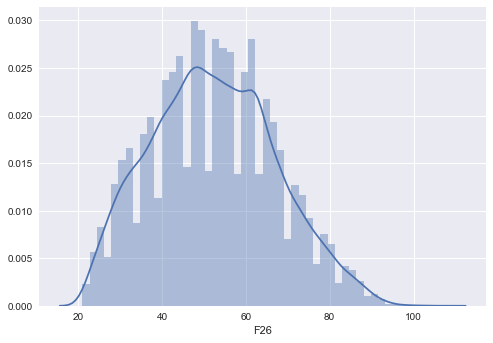

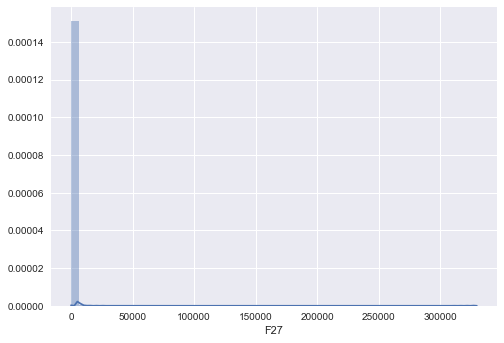

In [4]:
# Graph data. Added in normalization for some of the features due to curiosity, however I did not end up using normalized data
# I found that most features were binary or had a very small range making them unsuitable for normalization
# However, feature 10 and 22 had "vaguely" normal distributions with outliers removed, just needing some skew (sqrt or log)
q = train_final.quantile(0.95)
print q
train_final["F22"] = np.sqrt(train_final["F22"])
train_final["F10"] = train_final[train_final["F10"] < q["F10"]]
train_final["F10"] = np.sqrt(train_final["F10"])
print train_final["F1"]
for x in train_final.columns:
    sns.distplot(train_final[x])
    sns.plt.show()

# Standalone XGBoost Regression with GridSearchCV

In [6]:
# xgboost block, contains most successful model.
# trained w/ GridSearchCV to find optimal hyperparameters in isolation or small sets.
X_train = train_final.loc[:, a]
X_train_meta = X_train
X_test_meta = test_final
y_train = train_final.loc[:, "Y"]
parameters = {
    'base_score' : [0.1, 0.3, 0.5, 0.7, 1],
    'colsample_bytree' : [0.1, 0.3, 0.5, 0.7, 1],
    'scale_pos_weight' : [1,2,3,4,5,6],
    'max_depth' : [1,2,3,4,5,6],
    'reg_alpha' : [0, 0.1, 0.25, 0.5, 0.7, 1, 2, 5]
}
xgmodel = xgb.XGBRegressor(base_score=0.1, colsample_bytree=0.3, gamma=1, learning_rate=0.1, max_depth=5, max_delta_step=0.5, min_child_weight=6, n_estimators=200, 
                           reg_alpha=0.25, scale_pos_weight=1, subsample=1)
xg_clf = GridSearchCV(xgmodel, parameters, cv = 5, scoring = "roc_auc").fit(X_train, y_train)
#xg_clf = xg.clf.fit(X_train, y_train)
#xgmodel = xgmodel.fit(X_train, y_train)
#y_pred = xg_clf.predict(test_final)
#print cross_val_score(xg_clf, X_train, y_train, cv=5, scoring="roc_auc").mean()

# 0.859089238176
# {'reg_alpha': 0.1, 'gamma': 1}
# 0.859089238176
# {'reg_alpha': 0.25}
# 0.859353681675
# {'max_depth': 3}
# 0.858230410122
# {'gamma': 1}
# 0.84??
# {'n_estimators': 10} - n_estimators is a bigger value, and tested with max=10. trying again
# 0.858419432314
# {'n_estimators': 200}
# 0.858230423628
# {'learning_rate': 0.1}
# 0.85835291091
# {'max_delta_step': 0.5}
# 0.860458981298
# {'scale_pos_weight': 2}
# 0.860458981298
# {'reg_lambda': 1}
# 0.860458981298
# {'subsample': 1}
# 0.860661620264
# {'colsample_bytree': 0.3}
# 0.860601694209
# {'base_score': 0.7}
# 0.860601694209
# {'min_child_weight': 6}
# 0.860939573602
# {'scale_pos_weight': 3, 'colsample_bytree': 0.7, 'base_score': 0.7} Best kaggle score
# 0.861020663544
# {'scale_pos_weight': 1, 'colsample_bytree': 0.3, 'max_depth': 5, 'base_score': 0.1}

starting
frame stuff
got here


KeyboardInterrupt: 

In [19]:
# Results of the xgboost block. Modularized so that it was not necessary to rerun the GridSearchCV
# Whenever I wanted to view the result, also provide other info such as best score to compare with cross_val_score,
# and the model to see the implementations of the hyperparameters in action.
print xg_clf.best_score_
print xg_clf.best_params_
print xgmodel
y_pred = xg_clf.predict(test_final)

0.861020663544
{'scale_pos_weight': 1, 'colsample_bytree': 0.3, 'max_depth': 5, 'base_score': 0.1}
XGBRegressor(base_score=0.7, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=1, learning_rate=0.1, max_delta_step=0.5, max_depth=3,
       min_child_weight=6, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0.25, reg_lambda=1,
       scale_pos_weight=3, seed=0, silent=True, subsample=1)


# Stacking Regressor, low cross_val_score and long runtimes

In [42]:
#monstrous stacking regressor code - not used due to poor performance even for strong estimators, reason unknown.
X_train = train_final.loc[:, a]
X_train_meta = X_train
X_test_meta = test_final
y_train = train_final.loc[:, "Y"]
alphas = [0.000005, 0.0005, 0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100, 125, 150, 200, 10000]

X_train = X_train.fillna(X_train.mean())
test_final = test_final.fillna(test_final.mean())

parameters = {
    'max_depth':[4,5,6,7,8,9, 10],
    #'n_estimators':[25, 50, 100, 150, 200],
    'reg_alpha' : [0.001, 0.05, 0.1, 0.25, 0.5]
    #'minimum_child_weight' : [1,2,3,4,5]
}

#clf1 = GridSearchCV(xgb.XGBRegressor(), parameters, cv=5, n_jobs=4, scoring='roc_auc')
xgb = xgb.XGBRegressor(learning_rate=0.1, nthread=4, max_delta_step=3)

clf2 = ExtraTreesRegressor(random_state=2016)
#clf4 = SVR(kernel='rbf')
clf3 = RandomForestRegressor(random_state=12323)
stacker = xgb.XGBRegressor()
svr_rbf = SVR(kernel='rbf')
sclf = StackingRegressor(regressors=[clf1, clf2, clf3], 
                          meta_regressor=stacker)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Xgb', 
                       'Random Forest',
                       'SVR',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    print("Accuracy: %0.6f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
sclf = sclf.fit(X_train, y_train)
y_pred = sclf.predict(test_final)

3-fold cross validation:

Accuracy: 0.857703 (+/- 0.01) [Xgb]
Accuracy: 0.767417 (+/- 0.01) [Random Forest]
Accuracy: 0.773986 (+/- 0.01) [Random Forest]
Accuracy: 0.613052 (+/- 0.00) [SVR]


In [7]:
clf1 = xgb.XGBRegressor()
scores = cross_val_score(clf1, X_train, y_train, cv=5, scoring='roc_auc')
print("Accuracy: %0.6f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), "xgb"))

Accuracy: 0.859219 (+/- 0.01) [xgb]


# Ridge and Lasso Regression as well as Stacking loop

In [ ]:
# Block originally for simple Ridge and Lasso regression, tried manual stacking implementation,
# implementation was a failure and there is built in implementation from python anyway.

# 49998 entries before dropna, 40170 entries after. This is too many dropped in my opinion. Will try filling them in
#train_nonull = train_final.dropna(axis=0,how="any") 
#print train_nonull

#for i in range (len(a)):
#    if train_final.loc[:,a[i]].isnull().values.__contains__("True"):
#        print i


#This code prints that F5 and F19 are the only two columns with NaN values
#print train_final.isnull().any()
#train_final[np.abs(train_final.F6-train_final.F6.mean())<=(3*train_final.F6.std())] 
#train_final[~(np.abs(train_final.F6-train_final.F6.mean())>(3*train_final.F6.std()))]




X_train = train_final.loc[:, a]
X_train_meta = X_train
X_test_meta = test_final
y_train = train_final.loc[:, "Y"]

X_train = X_train.fillna(X_train.mean())
test_final = test_final.fillna(test_final.mean())

lr = LogisticRegression(random_state=20216)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(test_final)
print cross_val_score(lr, X_train, y_train, cv=5, scoring="roc_auc").mean()

linr = LinearRegression()
linr = linr.fit(X_train, y_train)
y_pred = linr.predict(test_final)
print cross_val_score(linr, X_train, y_train, cv=5, scoring="roc_auc").mean()


model_list = [lr,linr]
train_apend = np.zeros((X_train.shape[0], len(model_list)))
train_apend = np.zeros((test_final.shape[0], len(model_list)))
ridge_partial = RidgeCV(alphas=[0.000005, 0.0005, 0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100, 125, 150, 200, 10000])
kf = KFold(n_splits = 5, random_state=2016)
for i, mod in enumerate(model_list):
    for train_index, test_index in kf.split(X_train):
        X_partial = X_train[train_index[0]:train_index[-1]]
        y_partial = y_train[train_index[0]:train_index[-1]]
        X_holdout = X_train[test_index[0]:test_index[-1]]
        mod.fit(X_partial, y_partial)
        asdfdf = mod.predict(X_holdout)
        train_apend[train_index[0]:train_index[-1], i] = asdfdf[:]
    
    
"""#create a stacked ridge regression
alphas = [0.000005, 0.0005, 0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100, 125, 150, 200, 10000]
ridge = RidgeCV(alphas = alphas)
ridge = ridge.fit(X_train, y_train)
print ridge.alpha_
scores1 = cross_val_score(ridge, X_train, y_train, cv=5, scoring="roc_auc")
print str(scores1.mean()) + "    " + str(scores1.std()*3)
y_pred1 = ridge.predict(test_final)
X_test_meta["ridge"] = y_pred1

#create a stacked lasso regression
lasso = LassoCV(alphas = alphas)
lasso = lasso.fit(X_train,y_train)
print lasso.alpha_
scores2 = cross_val_score(lasso, X_train, y_train, cv=5, scoring="roc_auc")
print str(scores2.mean()) + "    " + str(scores2.std()*3)
y_pred2 = ridge.predict(test_final)
X_test_meta["lasso"] = y_pred2"""


stack_mod = Ensemble(5, LogisticRegression(random_state=2016), [lr, linr])
y_pred = stack_mod.fit_predict(X_train, y_train, test_final)


# Another attempt at manual stacking (unsuccessful)

In [ ]:
"""partial_pred = []

ridge_partial = RidgeCV(alphas=[0.000005, 0.0005, 0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100, 125, 150, 200, 10000])
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X_train):
    X_partial = X_train[train_index[0]:train_index[-1]]
    y_partial = y_train[train_index[0]:train_index[-1]]
    y_pred_partial = y_train[test_index[0]:test_index[-1]]
    ridge_partial = ridge_partial.fit(X_partial, y_partial)
    asdfdf = ridge_partial.predict(y_pred_partial)
    partial_pred[train_index[0]:train_inex[-1]] = asdfdf"""

# Submission Block

In [20]:
# Due to the way DataFrames act (similar to dictionaries) the columns have to be reordered for the output format to work.
# By default, the 2 columns were backwards.

submission = pd.DataFrame({"Y":y_pred, "id":id_val})
submission = submission[submission.columns[::-1]]
submission.to_csv("prediction_xgboost_tuned_v6.csv", index=False)